# Temperature-Dependent Power Flow

We implement Temperature-Dependent Power Flow (TDPF) in pandapower based on the following publications:

S. Frank, J. Sexauer and S. Mohagheghi, "Temperature-dependent power flow", IEEE Transactions on Power Systems, vol. 28, no. 4, pp. 4007-4018, Nov 2013.

B. Ngoko, H. Sugihara and T. Funaki, "A Temperature Dependent Power Flow Model Considering Overhead Transmission Line Conductor Thermal Inertia Characteristics," 2019 IEEE International Conference on Environment and Electrical Engineering and 2019 IEEE Industrial and Commercial Power Systems Europe (EEEIC / I&CPS Europe), 2019, pp. 1-6, doi: 10.1109/EEEIC.2019.8783234.

This tutorial demonstrates how to use this feature in pandapower in order to calculate temperature of overhead lines and also obtain the results of the TDPF with the adjusted line parameters. Furthermore, thermal inertia of overhead lines can be considered by specifying the time delay after which the temperature should be calculated. This implementation also supports the distributed slack power flow calculation.

We use the approach from Frank et al. to calculate the thermal resistance of the lines and to define the Jacobian matrix and the mismatch eqiation. The approach of Ngoko et al. is used to update the thermal resistance based on the line current and the weather parameters, and to introduce the thermal delay term in the Jacobian matrix. This allows using both methods. Furthermore, the approach to use thermal resistance is more versatile because it allows expanding the implementation for underground cables and transformers in the future.

This implementation will be of benefit for grid studies of Dynamic Line Rating (DLR). In addition, a calculation of a grid state at a specified time after an N-1 event provides additional capabilities for contingency studies and for obtaining emergency line ratings for a given grid. 

In this tutorial, we demonstrate the use of this feature with a small example.

After importing the necessary libraries, we create a 5-bus power system (inspired by Ngoko et al.) that we use to demonstrate the calculation:

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pandapower as pp
import pandapower.plotting
from pandapower.test.loadflow.test_tdpf import simple_test_grid
from pandapower.pf.create_jacobian_tdpf import *

In [2]:
net = simple_test_grid(load_scaling=0.25, sgen_scaling=0.5, with_gen=True, distributed_slack=False)

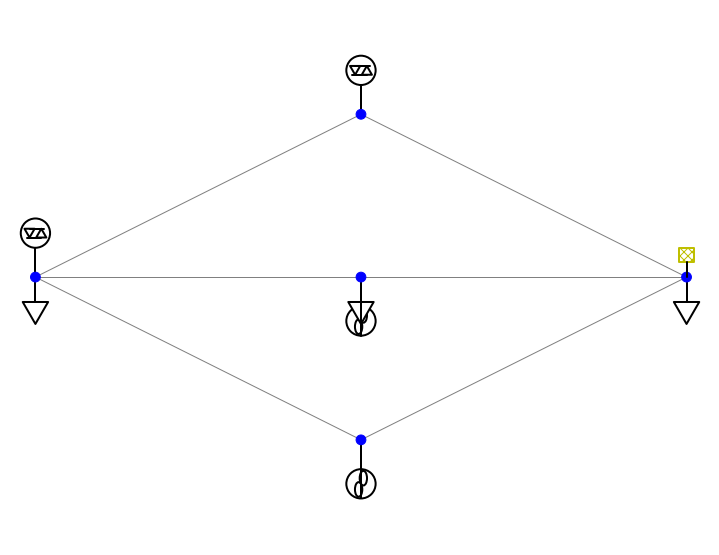

<AxesSubplot:>

In [3]:
pp.plotting.simple_plot(net, plot_loads=True, plot_sgens=True, plot_gens=True, load_size=3, sgen_size=3, gen_size=3)

In [4]:
pp.runpp(net)
net.res_line

,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,pl_mw,ql_mvar,i_from_ka,i_to_ka,i_ka,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,loading_percent
0,2.520700,56.677782,-2.264601,-55.071738,0.256099,1.606044,0.241507,0.241507,0.241507,1.027490,2.981261,0.998232,3.173039,25.156976
1,97.479300,-56.677782,-96.467660,63.021966,1.011640,6.344184,0.479997,0.479997,0.479997,1.027490,2.981261,1.050000,0.000000,49.999724
2,-88.710098,11.671945,89.248383,-8.296260,0.538285,3.375684,0.392043,0.392043,0.392043,0.998232,3.173039,1.000000,5.357838,40.837850
3,65.974699,-16.600207,-65.779624,17.823557,0.195075,1.223350,0.298086,0.298086,0.298086,0.998232,3.173039,1.000000,2.135568,31.050611
4,210.751617,-141.687706,-206.430677,168.785130,4.320941,27.097424,1.110752,1.110752,1.110752,1.000000,5.357838,1.050000,0.000000,115.703355
5,-113.442497,220.182604,115.779624,-205.526046,2.337127,14.656558,1.031768,1.031768,1.031768,1.050000,0.000000,1.000000,2.135568,107.475804


In [5]:
net.res_bus

,vm_pu,va_degree,p_mw,q_mvar
0,1.027490,2.981261,-100.000000,-0.000000
1,0.998232,3.173039,25.000000,60.000000
2,1.000000,5.357838,-300.000000,149.983966
3,1.050000,0.000000,416.340834,-451.989700
4,1.000000,2.135568,-50.000000,187.702489


## Calculation of the overhead line temperature

It is possible to use the functions from the implementation separately, in order to calculate the overhead line temperature.

The implementation in Ngoko et al. defines three terms to represent a simplified thermal model of an overhead line. The parameters $a_0$, $a_1$, and $a_2$ specify a constant, linear, and quadratic terms of the dependence of the line temperature from the square of the current $I$ that is flowing through the overhead line:

$$
T_{ss} = a_0 + a_1 \cdot I^2 + a_2 \cdot I^4
$$

$$
T = T_{ss} - (T_{ss} - T_0) \cdot \exp(-t/\tau)
$$

In the equations above, $T_{ss}$ stands for the steady-state temperature, $T_0$ is the initial temperature, and $T$ stands for the temperature at the time $t$ after a step change of current. The parameter $\tau$ is a time constant, used in the caluclation of line temperature with thermal inertia. After $\tau$ seconds, the temperature reaches approximately 63.2 % of the steady-state value.

This approach requires the following inputs (default values are in parentheses):

* air temperature (20 °C)
* initial line temperature (20 °C)
* reference temperature (20 °C)
* resistance at reference temperature (r_ohm_per_km)
* conductor outer diameter
* specific mass of the conductor multiplied by the specific thermal capacity of the material
* wind speed (0.6 m/s)
* wind angle of attack (45 °)
* solar radiation (900 W/m²)
* solar emissivity and solar absorptivity (0.5)
* thermal coefficient of resistivity (4.03e-3)

The parameters are specified in the net.line element table. If any parameters are missing, they will be substitutet by default assumptions. The parameter "tdpf" is always required. If the option to not update $R_\Theta$ is used, then "r_theta_kelvin_per_mw" is required. Otherwise, "conductor_outer_diameter_m" is required. Furthermore, if thermal inertia is considered by setting the option "tdpf_delay_s", the parameter "mc_joule_per_m_k" is required.

In [6]:
t_air_pu = 35
alpha_pu = 4.03e-3
r_ref = net.line.r_ohm_per_km.values / 1e3
a0, a1, a2, tau = calc_a0_a1_a2_tau(t_air_pu, 80, 20, r_ref, 30.6e-3,
                                    1490, 0.6, 45, 900, alpha_pu, 0.5, 0.5)
calc_T_ngoko(np.square(net.res_line.i_ka.values * 1e3), a0, a1, a2, None, None, None)

array([ 46.06044226,  53.12839992,  49.94224359,  47.29338662,
       100.09505835,  91.48530994])

In the approach of Frank et al., the parameters specifying the thermal model according to Ngoko et al. are used to calculate the thermal resistamce $R_{\Theta}$: 

$$
R_{\Theta} = \frac{T_{Rise}}{P_{Loss}} = \frac{a_0 - T_{air} + a_1 \cdot I^2 + a_2 \cdot I^4}{P_{Loss}}
$$

$$
T = T_{air} + R_\Theta \cdot P_{Loss}
$$

Alternatively, the thermal resistance can be approximated using an assumption for the rated temperature rise, as described in Frank et al. To this end, the air temperature $T_{air}$ and the temperature rise are added to calculate the line temperature. The temperature rise is calculated by multiplying the thermal resistance $R_\Theta$ and the active power losses $P_{Loss}$. The thermal resistance is included in the line results table.

In [7]:
branch = net._ppc["branch"]
tdpf_lines = np.ones(len(branch)).astype(bool)
r = branch[tdpf_lines, BR_R].real
#r = r * (1 + alpha_pu * (T - 20))
x = branch[tdpf_lines, BR_X].real
g, b = calc_g_b(r, x)
Vm = abs(net._ppc["internal"]["V"])
Va = np.angle(net._ppc["internal"]["V"])
i_square_pu, p_loss_pu = calc_i_square_p_loss(branch, tdpf_lines, g, b, Vm, Va)
#i_square_pu = np.square(net.res_line.i_ka.values*1e3)
r_theta_pu = calc_r_theta(t_air_pu, a0, a1, a2, np.square(net.res_line.i_ka.values*1e3), p_loss_pu)
calc_T_frank(p_loss_pu, t_air_pu, r_theta_pu, None, None, None)

array([ 46.06044226,  53.12839992,  49.94224359,  47.29338662,
       100.09505835,  91.48530994])

In [8]:
# using an approximation for the rated temperature rise:
r_theta_kelvin_per_mw = calc_r_theta_from_t_rise(net, 25)
calc_T_frank(p_loss_pu, t_air_pu, r_theta_kelvin_per_mw.values * net.sn_mva / 1, None, None, None)

array([36.43834877, 40.68175543, 38.79029548, 37.19122826, 65.42560553,
       61.25238291])

By providing the option tdpf=True, the overhead line temperature can be obtained from the power flow caluclation:

In [9]:
pp.runpp(net, tdpf=True, max_iteration=30)

Taking the results of the power flow calculation for the line current and using them as the input for the introduced functions, we can make sure that the temperature calculation delivers the same results. However, if we repeat the power flow calculation without the TDPF, the results will be different because the effect of the temperature on the resitance and the current is ignored.

In [10]:
net.res_line

,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,pl_mw,ql_mvar,i_from_ka,i_to_ka,i_ka,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,loading_percent,r_ohm_per_km,r_theta_kelvin_per_mw,temperature_degree_celsius
0,1.145704,57.860539,-0.851651,-56.191113,0.294053,1.669426,0.246226,0.246226,0.246226,1.028013,3.058060,0.998271,3.324106,25.648576,0.065172,37.924674,46.151857
1,98.854296,-57.860539,-97.672056,64.400365,1.182241,6.539826,0.487342,0.487342,0.487342,1.028013,3.058060,1.050000,0.000000,50.764815,0.066887,15.579987,53.419294
2,-89.838066,13.737926,90.460324,-10.255459,0.622257,3.482468,0.398196,0.398196,0.398196,0.998271,3.324106,1.000000,5.550365,41.478734,0.066113,24.328248,50.138432
3,65.689717,-17.546813,-65.473610,18.768694,0.216107,1.221881,0.297907,0.297907,0.297907,0.998271,3.324106,1.000000,2.284085,31.031951,0.065440,56.856682,47.287124
4,209.539677,-151.708806,-203.578073,179.827572,5.961603,28.118767,1.131492,1.131492,1.131492,1.000000,5.550365,1.050000,0.000000,117.863704,0.078446,11.305108,102.396570
5,-112.343080,225.658937,115.473611,-210.478384,3.130530,15.180553,1.050049,1.050049,1.050049,1.050000,0.000000,1.000000,2.284085,109.380148,0.076301,18.626449,93.310661


In [11]:
calc_T_ngoko(np.square(net.res_line.i_ka.values * 1e3), a0, a1, a2, None, None, None)

array([ 46.15308366,  53.42645102,  50.1425085 ,  47.28905922,
       102.50991728,  93.39730687])

In [12]:
pp.runpp(net)
calc_T_ngoko(np.square(net.res_line.i_ka.values * 1e3), a0, a1, a2, None, None, None)

array([ 46.06044226,  53.12839992,  49.94224359,  47.29338662,
       100.09505835,  91.48530994])

The calculation works for distributed slack power flow, too. However, the parameter net.sn_mva should be increased in order to avoid numerical instability.

In [13]:
net.sn_mva = 1000
pp.runpp(net, tdpf=True, tdpf_delay_s=5 * 60, distributed_slack=True, max_iteration=30)

Finally, we demonstrate the calculation with a time delay of 5 minutes:

In [14]:
pp.runpp(net, tdpf=True, tdpf_delay_s=5 * 60, max_iteration=30)

In [15]:
net.res_line

,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,pl_mw,ql_mvar,i_from_ka,i_to_ka,i_ka,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,loading_percent,r_ohm_per_km,r_theta_kelvin_per_mw,temperature_degree_celsius
0,2.169795,56.988937,-1.903741,-55.366515,0.266055,1.622422,0.242735,0.242735,0.242735,1.027632,3.001264,0.998243,3.212388,25.284924,0.060675,41.657558,27.096882
1,97.830205,-56.988937,-96.773739,63.383200,1.056465,6.394263,0.481888,0.481888,0.481888,1.027632,3.001264,1.050000,0.000000,50.196674,0.061132,17.225095,29.032648
2,-88.984503,12.221760,89.544640,-8.820053,0.560137,3.401707,0.393552,0.393552,0.393552,0.998243,3.212388,1.000000,5.407436,40.994956,0.060926,26.756068,28.159076
3,65.888243,-16.855245,-65.687504,18.077810,0.200740,1.222565,0.297990,0.297990,0.297990,0.998243,3.212388,1.000000,2.174414,31.040639,0.060752,61.219320,27.425004
4,210.455359,-144.382347,-205.708171,171.751230,4.747188,27.368883,1.116302,1.116302,1.116302,1.000000,5.407436,1.050000,0.000000,116.281463,0.064177,13.824373,41.937483
5,-113.143651,221.648526,115.687503,-206.853411,2.543852,14.795116,1.036633,1.036633,1.036633,1.050000,0.000000,1.000000,2.174414,107.982627,0.063617,22.370305,39.564852


We can see that the temperature rise is substantially lower due to thermal inertia. The thermal inertia effect can be illustrated in the following figure.

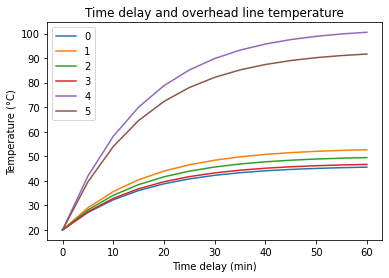

In [16]:
delays = np.arange(0, 65, 5)
delay_tab = pd.DataFrame(index=delays, columns=net.line.index.values)

for d in delays:
    pp.runpp(net, tdpf=True, tdpf_delay_s=d * 60, max_iteration=30)
    delay_tab.at[d, :] = net.res_line.temperature_degree_celsius.values
    
delay_tab.plot(ylabel="Temperature (°C)", xlabel="Time delay (min)", 
               title="Time delay and overhead line temperature");